This notebook is designed to compare the performance between accessing files over XRootD vs accessing files locally (on /hdfs). For both scenarios the exact same config file was used, running over 2 files from a dataset. Both sets of jobs were run on DICE (i.e. not interactively), and only 1 copy of each job was ever run simultaneously, to avoid any effects from multiple file requests.

Each setup was run 5 times, over the course of 2 days. The jobs take $\mathcal{O}(\text{1 hour})$, and an XRootD job was always submitted at the same time as a 'local' job, incase there were external effects (lots of proesses on nodes, etc). 

For the local runs, the files were first copied to /hdfs/user/ra12451, and then accessed in the config using `file:/hdfs/user/ra1245/...`. 

Files used: 

- `/store/mc/RunIISpring15DR74/QCD_Pt-15to3000_TuneCUETP8M1_Flat_13TeV_pythia8/GEN-SIM-RAW/NhcalZSHFscaleFlat10to30Asympt25ns_MCRUN2_74_V9-v1/00000/000E6EAA-E44E-E511-8C25-0025905A60AA.root`: 1728 events, 2.9 GB
- `/store/mc/RunIISpring15DR74/QCD_Pt-15to3000_TuneCUETP8M1_Flat_13TeV_pythia8/GEN-SIM-RAW/NhcalZSHFscaleFlat10to30Asympt25ns_MCRUN2_74_V9-v1/00000/003BEF9B-C24E-E511-B4B7-0025905A609E.root`: 2304 events, 3.8GB

Note that this study could be improved:

- Access more than 2 files to highlight any discrepancies - maybe they're too small to measure for 2 files, but noticeable for 20 files?
- Do more than 5 runs - not many data points!

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib as mpl
import pandas as pd
from matplotlib import dates
import datetime
import os

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12.0, 6.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.scatterpoints'] = 1

Get the output text from `/usr/bin/time -v` for each set of jobs (local, xrootd):

In [44]:
local_dir = 'log_local'
local_files = [os.path.join(local_dir, f) for f in os.listdir(local_dir) if f.endswith('.err')]
xrootd_dir = 'log_xrootd'
xrootd_files = [os.path.join(xrootd_dir, f) for f in os.listdir(xrootd_dir) if f.endswith('.err')]
print local_files
print xrootd_files

['log_local/SimL1Emulator_Stage2_profile_local_135730.153388.0.err', 'log_local/SimL1Emulator_Stage2_profile_local_164833.153391.0.err', 'log_local/SimL1Emulator_Stage2_profile_local_165832.153383.0.err', 'log_local/SimL1Emulator_Stage2_profile_local_182105.153393.0.err', 'log_local/SimL1Emulator_Stage2_profile_local_183130.153386.0.err']
['log_xrootd/SimL1Emulator_Stage2_profile_xrootd_140600.153389.0.err', 'log_xrootd/SimL1Emulator_Stage2_profile_xrootd_164228.153390.0.err', 'log_xrootd/SimL1Emulator_Stage2_profile_xrootd_170129.153384.0.err', 'log_xrootd/SimL1Emulator_Stage2_profile_xrootd_180907.153392.0.err', 'log_xrootd/SimL1Emulator_Stage2_profile_xrootd_182909.153385.0.err']


In [45]:
def get_profile_dict(log_filename):
    """Return time info as a dict"""
    with open(log_filename) as log_file:
        parse_line = False
        log_dict = {}
        for line in log_file.readlines():
            if 'Command being timed' in line:
                parse_line = True
            if parse_line:
                parts = line.strip().split(": ")
                log_dict[parts[0]] = parts[1]
#         print log_dict
        return log_dict

In [46]:
local_dicts = [get_profile_dict(f) for f in local_files]
xrootd_dicts = [get_profile_dict(f) for f in xrootd_files]

In [47]:
from pprint import pprint
pprint(local_dicts[0])

{'Average resident set size (kbytes)': '0',
 'Average shared text size (kbytes)': '0',
 'Average stack size (kbytes)': '0',
 'Average total size (kbytes)': '0',
 'Average unshared data size (kbytes)': '0',
 'Command being timed': '"cmsRun wrapper.py"',
 'Elapsed (wall clock) time (h:mm:ss or m:ss)': '36:35.80',
 'Exit status': '0',
 'File system inputs': '6551248',
 'File system outputs': '61024',
 'Involuntary context switches': '4762',
 'Major (requiring I/O) page faults': '3785',
 'Maximum resident set size (kbytes)': '1327744',
 'Minor (reclaiming a frame) page faults': '12562681',
 'Page size (bytes)': '4096',
 'Percent of CPU this job got': '88%',
 'Signals delivered': '0',
 'Socket messages received': '0',
 'Socket messages sent': '0',
 'Swaps': '0',
 'System time (seconds)': '28.82',
 'User time (seconds)': '1919.20',
 'Voluntary context switches': '105633'}


In [48]:
def get_values(dicts, key):
    """Return list of values for a given key from the list of dicts."""
    return [d[key] for d in dicts]

def get_values_float(dicts, key):
    """Return numpy array of float values for a given key from the list of dicts."""
    return np.array([float(d[key]) for d in dicts])

def get_values_time(dicts, key):
    """Return numpy array of datetime values for a given key from the list of dicts."""

    def get_time(string):
        """Convert string to ddatetime.time object"""
        n_colons = string.count(":")
        if n_colons == 1:
            return datetime.datetime.strptime(string, '%M:%S.%f')
        elif n_colons == 2:
            return datetime.datetime.strptime(string, '%H:%M:%S.%f')

    return np.array([get_time(d[key]) for d in dicts])

In [49]:
print get_values(local_dicts, 'Maximum resident set size (kbytes)')
print get_values(xrootd_dicts, 'Maximum resident set size (kbytes)')

['1327744', '1325712', '1343168', '330956', '1329936']
['1427776', '1326880', '1417888', '1452416', '332356']


In [50]:
print get_values_time(local_dicts, 'Elapsed (wall clock) time (h:mm:ss or m:ss)')
print get_values_float(local_dicts, 'Page size (bytes)')

[datetime.datetime(1900, 1, 1, 0, 36, 35, 800000)
 datetime.datetime(1900, 1, 1, 0, 43, 7, 950000)
 datetime.datetime(1900, 1, 1, 0, 42, 48, 550000)
 datetime.datetime(1900, 1, 1, 0, 38, 52, 730000)
 datetime.datetime(1900, 1, 1, 0, 46, 26, 630000)]
[ 4096.  4096.  4096.  4096.  4096.]


In [51]:
to_seconds = lambda x: x.hour*3600 + x.minute*60 + x.second + x.microsecond/1.E6

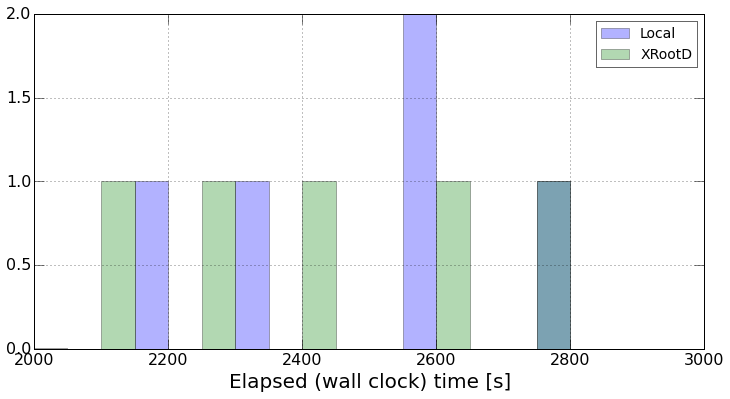

In [52]:
nbins= 20
xlim = [2000, 3000]
plt.hist(map(to_seconds, get_values_time(local_dicts, 'Elapsed (wall clock) time (h:mm:ss or m:ss)')), 
         label='Local', alpha=0.3, bins=nbins, range=xlim, histtype='bar')
plt.hist(map(to_seconds, get_values_time(xrootd_dicts, 'Elapsed (wall clock) time (h:mm:ss or m:ss)')),
         label='XRootD', alpha=0.3, bins=nbins, range=xlim, histtype='bar')
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel('Elapsed (wall clock) time [s]')

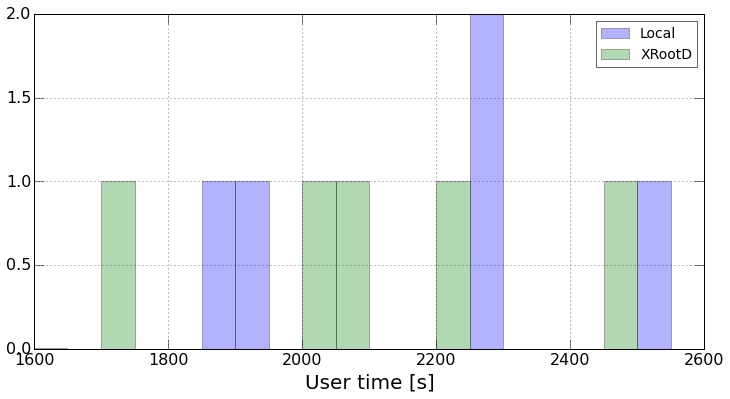

In [53]:
nbins = 20
xlim = [1600, 2600]
plt.hist(get_values_float(local_dicts, 'User time (seconds)'), 
         label='Local', alpha=0.3, bins=nbins, range=xlim)
plt.hist(get_values_float(xrootd_dicts, 'User time (seconds)'),
         label='XRootD', alpha=0.3, bins=nbins, range=xlim)
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel('User time [s]')

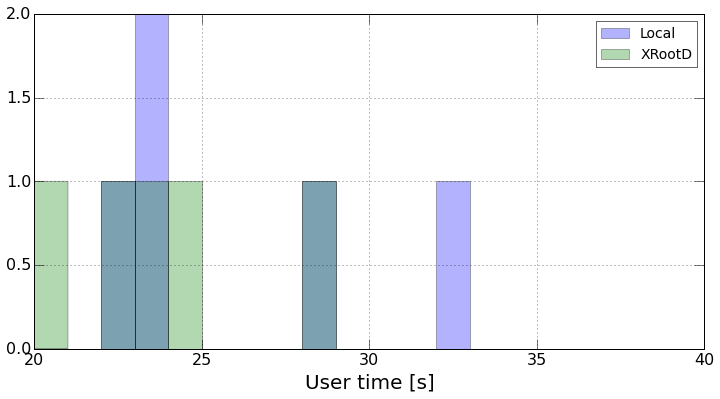

In [54]:
nbins = 20
xlim = [20, 40]
plt.hist(get_values_float(local_dicts, 'System time (seconds)'), 
         label='Local', alpha=0.3, bins=nbins, range=xlim)
plt.hist(get_values_float(xrootd_dicts, 'System time (seconds)'),
         label='XRootD', alpha=0.3, bins=nbins, range=xlim)
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel('User time [s]')

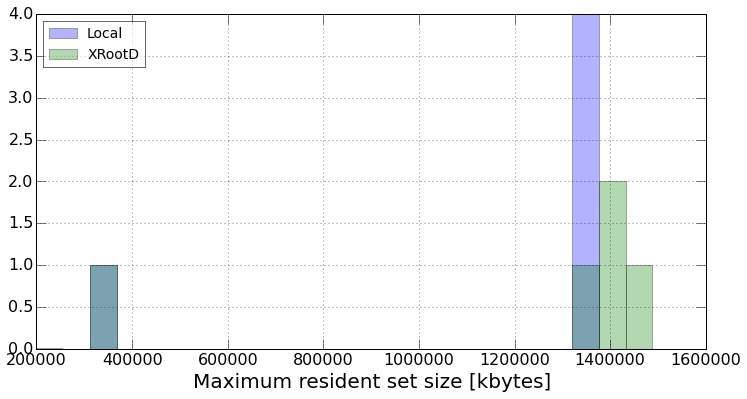

In [58]:
nbins = 25
xlim = [200000, 1600000]
plt.hist(get_values_float(local_dicts, 'Maximum resident set size (kbytes)'), 
         label='Local', bins=nbins, range=xlim, alpha=0.3)
plt.hist(get_values_float(xrootd_dicts, 'Maximum resident set size (kbytes)'),
         label='XRootD', bins=nbins, range=xlim, alpha=0.3)
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel('Maximum resident set size [kbytes]')

## Conclusion

It appears that there is very little difference (for my script, at least) getting files via XRootD vs getting files locally. However, one should note the caveats at the start of this document.